# Лабораторная работа №2: Анализ ассоциативных правил
## 1. Введение
**Цель работы:** исследование методов анализа ассоциативных правил.

**Постановка задачи:** провести исследование методов анализа ассоциативных правил на датасете с Kaggle:
1. Загрузить датасет из репозитория (например, kaggle.com или аналогичных платформ). Данные должны представлять собой информацию о купленных вместе товарах .
2. Привести описание данных из датасета: график вывода длин транзакций, список уникальных товаров и др. 
3. Алгоритм Apriori: выполнить анализ ассоциативных правил при помощи алгоритма Apriori с изначальными условиями в соответствии с вариантом задания. Проанализировать полученные результаты, выделив полезные и тривиальные правила, и оценив значение достоверности, лифта правил. Провести оценку влияния параметров алгоритма на получаемые правила (на количество правил и метрики).
4. Алгоритм FPG: провести анализ правил, используя алгоритм FPG. В отчете привести правила, получившиеся в результате использования данного алгоритма.
5. Алгоритмически определить минимальные значения поддержки для составления правил из 1, 2, и т.д. объектов в одном из алгоритмов.
6. Последовательно меняя параметры (значения поддержки и достоверности) одного из алгоритмов получить наборы ассоциативных правил. Сделать выводы на основе проведенных экспериментов.
7. Проанализировать получающийся в результате работы программы граф. Объяснить, какую информацию можно из него извлечь.
8. Предложить и реализовать свой способ визуализации ассоциативных правил и метрик.
## 2. Анализ данных:
Датасет **Market Basket Optimisation** содержит информацию о покупках в продуктовом магазине. Каждая строка — это транзакция (корзина покупок), в которой перечислены купленные товары. Пропущенные значения обозначают отсутствие товара в корзине.

           shrimp    almonds     avocado    vegetables mix green grapes  \
0         burgers  meatballs        eggs               NaN          NaN   
1         chutney        NaN         NaN               NaN          NaN   
2          turkey    avocado         NaN               NaN          NaN   
3   mineral water       milk  energy bar  whole wheat rice    green tea   
4  low fat yogurt        NaN         NaN               NaN          NaN   

  whole weat flour yams cottage cheese energy drink tomato juice  \
0              NaN  NaN            NaN          NaN          NaN   
1              NaN  NaN            NaN          NaN          NaN   
2              NaN  NaN            NaN          NaN          NaN   
3              NaN  NaN            NaN          NaN          NaN   
4              NaN  NaN            NaN          NaN          NaN   

  low fat yogurt green tea honey salad mineral water salmon antioxydant juice  \
0            NaN       NaN   NaN   NaN           NaN    NaN

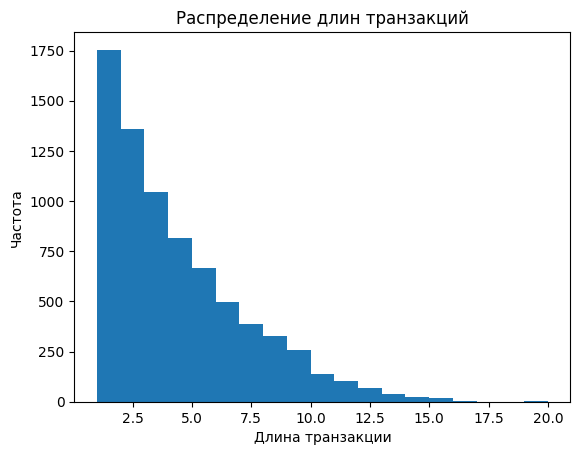

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import networkx as nx
import numpy as np

all_data = pd.read_csv('Market_Basket_Optimisation.csv')
print(all_data.head())

transaction_lengths = all_data.notnull().sum(axis=1)
plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths) + 2))
plt.xlabel('Длина транзакции')
plt.ylabel('Частота')
plt.title('Распределение длин транзакций')
plt.show()


In [34]:
np_data = all_data.to_numpy()
np_data = [[elem for elem in row[1:] if isinstance(elem,str)] for row in np_data]

unique_items = set()
for row in np_data:
    for elem in row:
        unique_items.add(elem)
print(unique_items)
print(f"Всего уникальных товаров: {len(unique_items)}")

# Преобразование в бинарный формат
te = TransactionEncoder()
te_ary = te.fit(np_data).transform(np_data)
data = pd.DataFrame(te_ary, columns=te.columns_)

{'fresh tuna', 'dessert wine', 'chocolate', 'cooking oil', 'burger sauce', 'pickles', 'whole wheat rice', 'ham', 'olive oil', 'salad', 'low fat yogurt', 'body spray', 'eggplant', 'butter', 'whole weat flour', 'shrimp', 'mint', 'shallot', 'babies food', 'salmon', 'extra dark chocolate', 'clothes accessories', 'green beans', 'herb & pepper', 'almonds', 'green grapes', 'honey', 'hot dogs', 'protein bar', 'light mayo', 'fresh bread', 'eggs', 'mushroom cream sauce', 'chocolate bread', 'oil', 'yogurt cake', 'flax seed', 'red wine', 'milk', 'bug spray', 'salt', 'white wine', 'burgers', 'sandwich', 'pet food', 'mineral water', 'pasta', 'pepper', 'frozen vegetables', 'yams', 'cauliflower', 'gluten free bar', 'bramble', 'chicken', 'antioxydant juice', 'pancakes', 'champagne', 'blueberries', 'water spray', 'brownies', 'rice', 'turkey', 'cookies', 'barbecue sauce', 'fromage blanc', 'ground beef', 'cereals', 'grated cheese', 'cottage cheese', 'spinach', 'tea', 'corn', 'cream', 'cider', 'escalope', 

## 3. Ход работы:
### Алгоритм Apriori

Будем использовать начальные параметры:
- `min_support = 0.02`
- `min_confidence = 0.25`

Сначала найдём частые наборы товаров, затем сгенерируем ассоциативные правила.

     support                    itemsets
0   0.025600                   (avocado)
1   0.030667                  (brownies)
2   0.023200                    (butter)
3   0.068000                      (cake)
4   0.022400                   (cereals)
..       ...                         ...
59  0.029333           (milk, spaghetti)
60  0.023067  (olive oil, mineral water)
61  0.028000   (pancakes, mineral water)
62  0.046267  (spaghetti, mineral water)
63  0.020533       (spaghetti, pancakes)

[64 rows x 2 columns]
        antecedents      consequents  antecedent support  consequent support  \
0            (cake)  (mineral water)            0.068000            0.161333   
1       (chocolate)  (mineral water)            0.111733            0.161333   
2            (eggs)  (mineral water)            0.142533            0.161333   
3     (ground beef)  (mineral water)            0.069200            0.161333   
4     (ground beef)      (spaghetti)            0.069200            0.126933   
5    

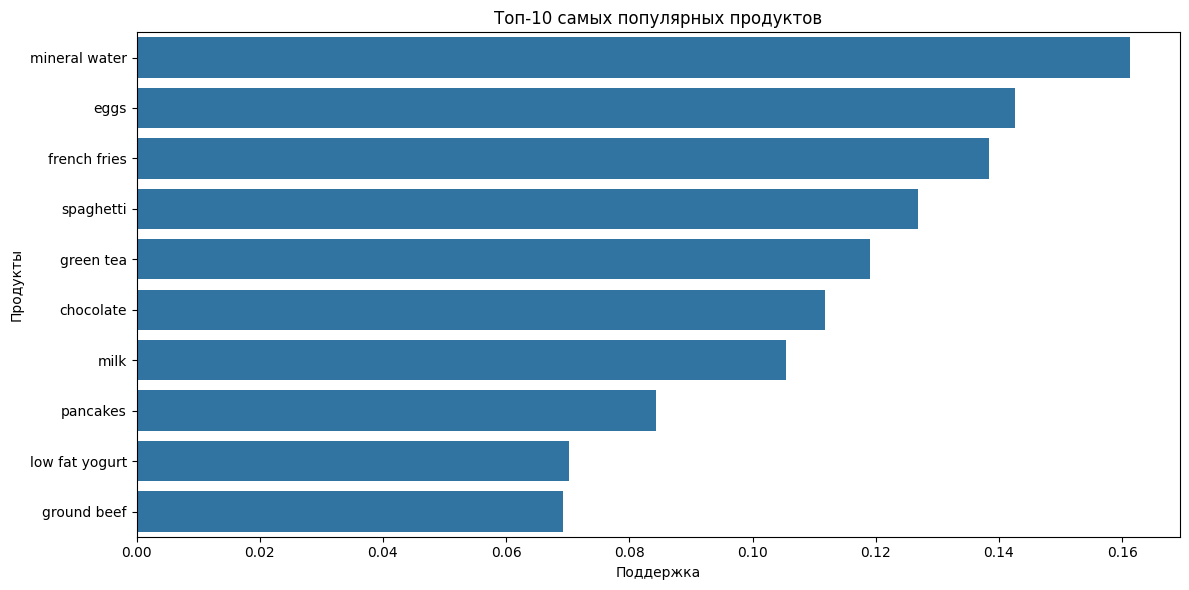

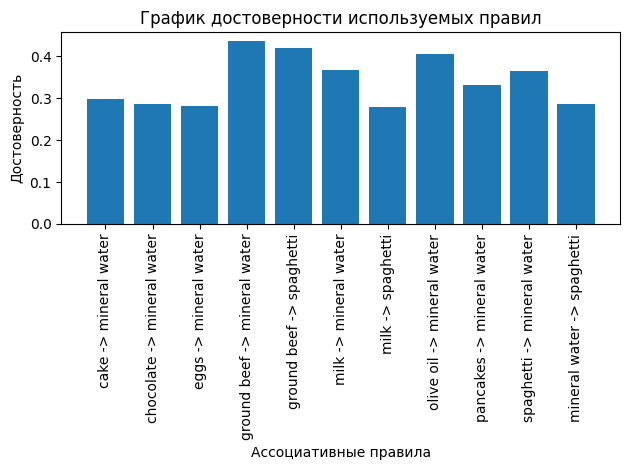

In [35]:
df1 = apriori(data, min_support=0.02, use_colnames = True)
print(df1)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.25)
print(rules)

print('-----------------------------------')

df1['itemsets'] = df1['itemsets'].apply(lambda x: ', '.join(list(x)))
top_products = df1.sort_values(by='support', ascending=False).head(10)
print(top_products)
plt.figure(figsize=(12, 6))
sns.barplot(x='support', y='itemsets', data=top_products)
plt.title('Топ-10 самых популярных продуктов')
plt.xlabel('Поддержка')
plt.ylabel('Продукты')
plt.tight_layout()
plt.show()

rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

#График достоверности используемых правил
products_1 = rules["antecedents"].tolist()
products_2 = rules["consequents"].tolist()
confidence = rules["confidence"].tolist()
rules_labels = [f"{product1} -> {product2}" for product1, product2 in zip(products_1, products_2)]
plt.bar(rules_labels, confidence)
plt.xlabel("Ассоциативные правила")
plt.ylabel("Достоверность")
plt.title("График достоверности используемых правил")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Частые наборы:**
64 шт. — включают как одиночные товары (avocado, brownies, cake), так и пары (milk + spaghetti, olive oil + mineral water).

**Ассоциативные правила:**
11 шт. — все они связывают один товар → другой.

Почти все правила включают mineral water — это самый популярный товар (support = 0.1613, т.е. встречается в 16.13% транзакций).

**Полезные правила (содержательные и практически значимые):**

Правило считается полезным, если:
1. Lift > 1.5 → сильная положительная зависимость
2. Confidence > 0.4 → надёжное правило
3. Cвязь логична и неочевидна.

Полезные правила:
1. ground beef → mineral water (confidence: 0.435453, lift: 2.699088). Покупка говядины повышает вероятность покупки воды. Возможно, связано с готовкой.
2. ground beef → spaghetti (confidence: 0.420039, lift: 3.309127). Очень сильная связь. Люди, покупающие говядину, часто берут спагетти — логично для приготовления блюд (болоньезе).
3. milk → mineral water (confidence: 0.366625, lift: 2.272466). Покупатели, берущие молоко, часто дополняют покупку бутилированной водой, возможно, закупая базовые продукты для дома.
4. olive oil → mineral water(confidence: 0.406103, lift: 2.517169). Люди, покупающие оливковое масло (часто как часть здорового рациона), склонны одновременно выбирать и бутилированную воду.
5. pancakes → mineral water (confidence: 0.331754, lift: 2.056324). При покупке панкейков (например, для завтрака или десерта) клиенты часто берут минеральную воду, как напиток к тприёму пищи.
6. spaghetti → mineral water (confidence: 0.364496, lift: 2.259271). Покупка спагетти часто сопровождается приобретением бутилированной воды, возможно, для приготовления или употребления во время еды.

**Тривиальные правила (малополезные):**
Правило тривиально, если:
1. Lift близок к 1 (все lift > 1.7 ),
2. Или правило основано только на популярности консеквента.

Потенциально тривиальные (но всё же значимые):
1. cake → mineral water (lift: 1.847351). Cake редок (6.8%), но вода — очень популярна. Правило работает, но в основном из-за популярности воды.
2. chocolate → mineral water (lift: 1.775183). Шоколад покупают часто (11.2%), вода — почти в 1/6 корзин. Связь есть, но слабее.
3. eggs → mineral water (lift: 1.751077). Яйца — второй по популярности товар (14.3%). Правило отражает общую тенденцию, а не специфическую связь.

**Оценка метрик:**

*Support*(насколько часто встречается набор): от 0.0205 (pancakes + spaghetti) до 0.1613 (mineral water).

*Confidence*(насколько часто правило верно): от 0.283 до 0.435 — все выше порога 0.25.

*Lift*(насколько наборы зависят друг от друга): от 1.75 до 3.31 — все правила значимы (lift > 1).

*Conviction*(частотность ошибок правила): от 1.17 до 1.51 — чем выше, тем менее вероятно, что правило случайно.

Все 11 правил статистически значимы (lift > 1), надёжны (confidence > 0.25) и не случайны (conviction > 1).Особенно выделяются правила с lift > 2.5 (ground beef → spaghetti, ground beef → water, olive oil → water).

**Влияние параметров на результаты:**

min_support = 0.02 → позволил найти редкие, но значимые пары (например, avocado, cereals).

min_confidence = 0.25 → дал 11 правил.
### Алгоритм FPG:


In [28]:
df1 = fpgrowth(data, min_support=0.02, use_colnames = True)
print(df1)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.25)
print(rules)

df1['itemsets'] = df1['itemsets'].apply(lambda x: ', '.join(list(x)))

rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))


     support                      itemsets
0   0.142533                        (eggs)
1   0.025600                     (avocado)
2   0.119067                   (green tea)
3   0.105467                        (milk)
4   0.052267            (whole wheat rice)
..       ...                           ...
59  0.020533         (pancakes, spaghetti)
60  0.030133  (ground beef, mineral water)
61  0.029067      (spaghetti, ground beef)
62  0.020267         (cake, mineral water)
63  0.023067    (olive oil, mineral water)

[64 rows x 2 columns]
        antecedents      consequents  antecedent support  consequent support  \
0            (eggs)  (mineral water)            0.142533            0.161333   
1            (milk)      (spaghetti)            0.105467            0.126933   
2            (milk)  (mineral water)            0.105467            0.161333   
3       (spaghetti)  (mineral water)            0.126933            0.161333   
4   (mineral water)      (spaghetti)            0.161333     

При использовании алгоритма FP-Growth с параметрами:

1. min_support = 0.02
2. min_confidence = 0.25

было получено 11 ассоциативных правил:
1. eggs → mineral water (support: 0.040267, confidence: 0.282507, lift: 1.751077)
2. milk → spaghetti (support: 0.029333, confidence: 0.278129, lift: 2.191142)
3. milk → mineral water (support: 0.038667, confidence: 0.366625, lift: 2.272466)
4. spaghetti → mineral water (support: 0.046267, confidence: 0.364496, lift: 2.259271)
5. mineral water → spaghetti (support: 0.046267, confidence: 0.286777, lift: 2.259271)
6. chocolate → mineral water (support: 0.032000, confidence: 0.286396, lift: 1.775183)
7. pancakes → mineral water (support: 0.028000, confidence: 0.331754, lift: 2.056324)
8. ground beef → mineral water (support: 0.030133, confidence: 0.435453, lift: 2.699088)
9. ground beef → spaghetti (support: 0.029067, confidence: 0.420039, lift: 3.309127)
10. cake → mineral water (support: 0.020267, confidence: 0.298039, lift: 1.847351)
11. olive oil → mineral water (support: 0.023067, confidence: 0.406103, lift: 2.517169)

### Определение минимальных значений поддержки

In [ ]:
min_support_for_k = {}

for support in np.arange(0.05, 0.000, -0.001):
    freq_itemsets = fpgrowth(data, min_support=support, use_colnames=True)
    
    if len(freq_itemsets) == 0:
        continue
    
    freq_itemsets['length'] = freq_itemsets['itemsets'].apply(lambda x: len(x))
    max_len = freq_itemsets['length'].max()
    
    for k in range(1, max_len + 1):
        if k not in min_support_for_k:
            min_support_for_k[k] = support

sorted_k = sorted(min_support_for_k.items())

print("Минимальная поддержка, при которой появляются наборы длины k:")
for k, sup in sorted_k:
    print(f"  k = {k}: min_support = {sup:.3f}")

Минимальная поддержка, при которой появляются наборы длины k:
  k = 1: min_support = 0.050
  k = 2: min_support = 0.046
  k = 3: min_support = 0.012
  k = 4: min_support = 0.003
  k = 5: min_support = 0.001


### Влияние парметров на результат

In [6]:
param_combinations = [
    (0.05, 0.40),
    (0.03, 0.30),
    (0.01, 0.20),
    (0.005, 0.15),

    (0.02, 0.35),
    (0.02, 0.25),
    (0.02, 0.20),

    (0.05, 0.25),
    (0.04, 0.25),
    (0.03, 0.25)
]

results = []

for min_sup, min_conf in param_combinations:
    freq_itemsets = fpgrowth(data, min_support=min_sup, use_colnames=True)
    n_itemsets = len(freq_itemsets)
    
    if n_itemsets > 0:
        rules = association_rules(freq_itemsets, metric="confidence", min_threshold=min_conf)
        n_rules = len(rules)

        avg_conf = rules['confidence'].mean() if n_rules > 0 else 0
        avg_lift = rules['lift'].mean() if n_rules > 0 else 0
    else:
        n_rules, avg_conf, avg_lift = 0, 0, 0
    
    results.append({
        'min_support': min_sup,
        'min_confidence': min_conf,
        'Частые наборы': n_itemsets,
        'Правила': n_rules,
        'Средняя достоверность': round(avg_conf, 3),
        'Средний лифт': round(avg_lift, 3)
    })

results_df = pd.DataFrame(results)
print("Результаты экспериментов:")
print(results_df.to_string(index=False))

Результаты экспериментов:
 min_support  min_confidence  Частые наборы  Правила  Средняя достоверность  Средний лифт
       0.050            0.40             16        0                  0.000         0.000
       0.030            0.30             31        3                  0.389         2.410
       0.010            0.20            174       98                  0.279         2.128
       0.005            0.15            431      426                  0.271         2.314
       0.020            0.35             64        5                  0.399         2.611
       0.020            0.25             64       11                  0.341         2.267
       0.020            0.20             64       28                  0.273         2.026
       0.050            0.25             16        0                  0.000         0.000
       0.040            0.25             25        3                  0.311         2.090
       0.030            0.25             31        6                  0.33

Когда оба параметра — и минимальная поддержка (min_support), и минимальная достоверность (min_confidence) — уменьшаются одновременно, наблюдается резкий рост как числа частых наборов, так и количества генерируемых правил. Например, при переходе от строгих условий (0.05/0.40) к мягким (0.005/0.15) число правил возрастает с нуля до 426. Однако это не всегда означает улучшение качества: несмотря на увеличение объёма, средняя достоверность снижается, а многие из новых правил могут быть статистически слабыми или практически незначимыми.

При фиксированной поддержке (например, min_support = 0.02) и снижении порога достоверности с 0.35 до 0.20 количество правил увеличивается с 5 до 28. Однако при этом средняя достоверность падает с 0.399 до 0.273, а средний лифт — с 2.611 до 2.026. Это означает, что более мягкие требования к достоверности действительно добавляют правила, но они в среднем становятся менее сильными и менее надёжными.

Если же изменять только поддержку, оставляя достоверность фиксированной (например, min_confidence = 0.25), то с уменьшением min_support количество правил последовательно растёт: при min_support = 0.05 правил нет, при 0.04 — появляются 3, при 0.03 — уже 6, а при 0.02 — 11.

Таким образом, слишком строгие условия приводят к потере потенциально полезных ассоциаций, а чрезмерно мягкие — к избыточному шуму. В рамках данной работы оптимальным представляется сочетание min_support = 0.02 и min_confidence = 0.25: оно обеспечивает достаточное количество содержательных правил с высоким лифтом и приемлемой достоверностью.

### Граф

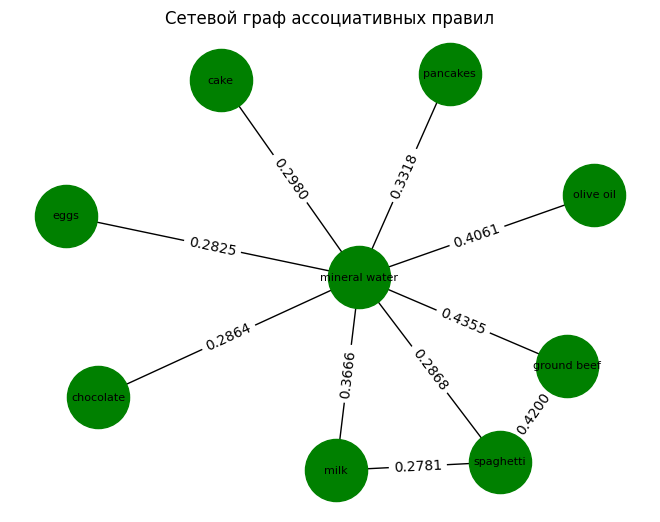

In [32]:
G = nx.Graph()
for product in rules["antecedents"]:
    G.add_node(product)
for product in rules["consequents"]:
    G.add_node(product)
for index, row in rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=row['confidence'])
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='green', font_size=8)
edge_labels = {k: f"{v:.4f}" for k, v in nx.get_edge_attributes(G, 'weight').items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('Сетевой граф ассоциативных правил')
plt.subplots_adjust()
plt.show()

Граф визуализирует связи между товарами: каждый узел — это отдельный продукт, а соединяющие их линии обозначают ассоциативные правила. Числа на рёбрах соответствуют достоверности (confidence) — то есть вероятности того, что при покупке одного товара будет куплен и второй.

Наиболее заметной особенностью графа является центральная роль товара «mineral water»: он связан с наибольшим числом других продуктов,. Это говорит о том, что минеральная вода часто приобретается вместе с другими товарами. Среди всех связей особенно выделяются те, где достоверность превышает 0.4 — например, правило «mineral water → ground beef» с confidence ≈ 0.435.

В то же время некоторые связи имеют более низкую достоверность (около 0.28–0.30), что говорит об их слабой, но всё же статистически значимой природе. Поскольку на рёбрах указаны только значения достоверности, полная оценка качества правила требует учёта и других метрик, таких как лифт, который показывает, насколько сильнее связь по сравнению со случайной. Тем не менее, даже в таком виде граф даёт наглядное и интуитивно понятное представление о ключевых зависимостях в данных, позволяя быстро выявить как сильные, так и слабые ассоциации между продуктами.
### Диаграмма рассеивания 

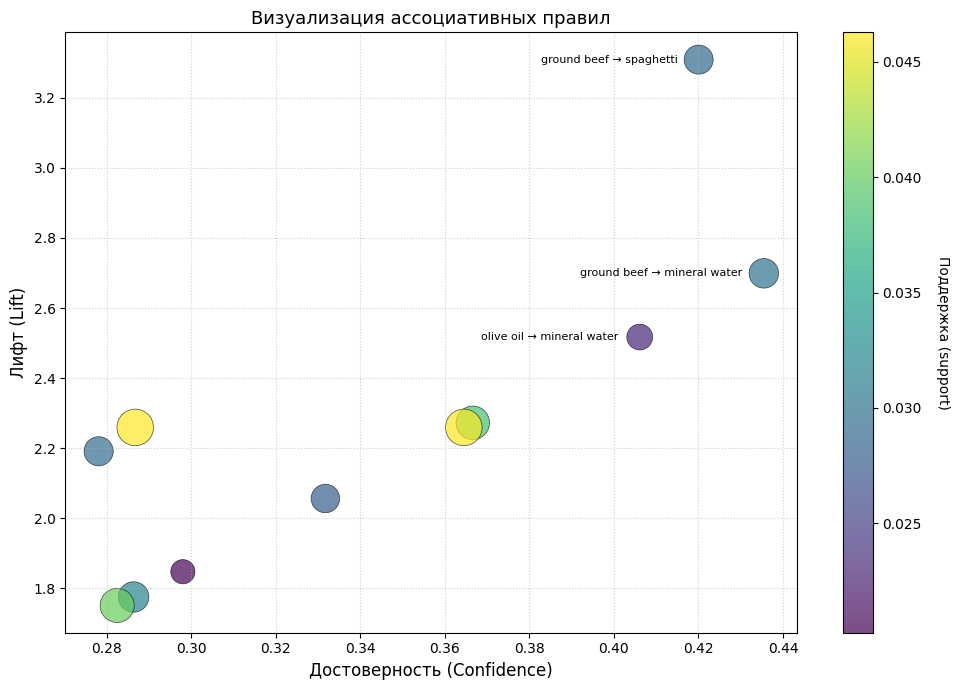

In [54]:
plt.figure(figsize=(10, 7))

scatter = plt.scatter(
    rules['confidence'],
    rules['lift'],
    s=rules['support'] * 15000,
    alpha=0.7,
    c=rules['support'],
    cmap='viridis',
    edgecolors='black',
    linewidth=0.5
)

cbar = plt.colorbar(scatter)
cbar.set_label('Поддержка (support)', rotation=270, labelpad=20)

plt.xlabel('Достоверность (Confidence)', fontsize=12)
plt.ylabel('Лифт (Lift)', fontsize=12)
plt.title('Визуализация ассоциативных правил', fontsize=13)
plt.grid(True, linestyle=':', alpha=0.6)

for i, row in rules.iterrows():
    if row['lift'] > 2.5 and row['confidence'] > 0.4:
        plt.text(
            row['confidence'] - 0.005,
            row['lift'],
            f"{row['antecedents']} → {row['consequents']}", 
            fontsize=8, 
            ha='right',
            va='center',
        )

plt.tight_layout()
plt.show()

Диаграмма рассеивания, представленная на графике, визуализирует ассоциативные правила в двумерном пространстве, где по горизонтальной оси откладывается достоверность (confidence), а по вертикальной — лифт (lift). Каждая точка на графике соответствует одному ассоциативному правилу, и её положение показывает, насколько надёжно и сильно это правило: чем правее и выше находится точка, тем выше его достоверность и лифт, что означает более высокую практическую ценность. Размер каждой точки пропорционален поддержке (support) правила — то есть чем крупнее шарик, тем чаще данная комбинация товаров встречается в транзакциях. Цветовая гамма, отображённая в виде боковой цветовой шкалы, также кодирует поддержку: от тёмных тонов (низкая поддержка) к светлым (высокая поддержка), что позволяет одновременно оценивать частоту события и его силу связи. На графике выделены наиболее значимые правила — те, у которых лифт превышает 2.5, а достоверность — 0.4.
## 4. Заключение
В результате выполнения лабораторной работы было проведено комплексное исследование методов анализа ассоциативных правил на датасете Market Basket Optimisation с использованием алгоритмов Apriori и FP-Growth. Большинство корзин содержат от 2 до 6 товаров, а общее число уникальных позиций равнялось 120, при этом лидирующую позицию занимает «mineral water».

Применение алгоритма FP-Growth с начальными параметрами (min_support = 0.02, min_confidence = 0.25) позволило выявить 11 содержательных ассоциативных правил, большинство из которых включают «mineral water». Наиболее значимым оказалось правило «ground beef → spaghetti» с лифтом 3.31 и достоверностью 0.42, что свидетельствует о сильной неслучайной связи, вероятно, обусловленной кулинарными привычками. Все полученные правила имели лифт выше 1.7, что подтверждает их статистическую значимость и практическую ценность.

Исследование влияния параметров выявило чёткую зависимость между порогами поддержки и достоверности и количеством генерируемых правил. Снижение обоих параметров одновременно приводило к росту числа правил, но сопровождалось падением средней достоверности и увеличением доли слабых связей. При этом фиксация одного параметра и варьирование другого позволило установить, что именно поддержка в большей степени управляет полнотой анализа, а достоверность — его надёжностью. Было также определено, что для выявления наборов из трёх и более товаров требуется снижение min_support до 0.01 и ниже, что подчеркивает редкость сложных комбинаций в реальных покупках.

Таким образом, работа продемонстрировала высокую эффективность методов анализа ассоциативных правил для выявления скрытых зависимостей в рыночных данных.